## **TAREA 4: Análisis de Estimaciones de Pobreza Comunal en Chile - 2022**

**Autores:** Simón Ramirez - Victor Saldivia - Carlos Saquel  
**Asignatura:** Visualización de la Información

Este análisis tiene como objetivo explorar las estimaciones de pobreza por ingresos y pobreza multidimensional en las comunas de Chile durante el año 2022. Los datos fueron obtenidos a partir de los conjuntos de datos proporcionados por el Ministerio de Desarrollo Social y Familia de Chile a través del Ministerio de Desarrollo Social y Familia. Se presenta un análisis descriptivo y visualizaciones para comprender de mejor forma las correlaciones y características de la pobreza en las comunas del país.

### **IMPORTACIÓN DE LIBRERÍAS**

In [1]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.patches as patches
from matplotlib import lines
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
from matplotlib.collections import PathCollection
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import PercentFormatter, MultipleLocator
import geopandas as gpd

from mpl_toolkits.axisartist.grid_finder import DictFormatter
import mpl_toolkits.axisartist.floating_axes as floating_axes

import matplotlib.font_manager as fm

import warnings
warnings.filterwarnings("ignore")

### **CARGA DEL DATASET**
El archivo que vamos a utilizar contiene información sobre las estimaciones de pobreza en Chile para el año 2022, tanto de ingresos como multidimensional. 


In [2]:
file_path_1 = './data/Estimaciones_Indice_Pobreza_Multidimensional_Comunas_2022.xlsx'
file_path_2 = './data/Estimaciones_Tasa_Pobreza_Ingresos_Comunas_2022.xlsx'
file_path_comunas = './Comunas/comunas.shp'

### **FUNCIONES DE LIMPIEZA DE LOS DATOS**


In [3]:
# Funciones de limpieza de columnas y acentos
def accent_replace(col):
    reemplazos = {
        'á': 'a', 'é': 'e', 'í': 'i', 'ó': 'o', 'ú': 'u',
        'Á': 'A', 'É': 'E', 'Í': 'I', 'Ó': 'O', 'Ú': 'U',
    }
    for acento, sin_acento in reemplazos.items():
        col = col.replace(acento, sin_acento)
    return col

def columns_clean(columnas):
    columnas_limpias = []
    for col in columnas:
        col = accent_replace(col).lower().replace('\n', '')
        col = re.sub(r'\(.*?\)', '', col).replace('*', '').replace(' ', '_')
        col = re.sub(r'[^a-z0-9_]', '', col).rstrip('_')
        columnas_limpias.append(col)
    return columnas_limpias

def get_clean_data(file, get_rows):
    df = pd.read_excel(file, skiprows=get_rows[0])
    df = df.iloc[:get_rows[1]]
    df.columns = columns_clean(df.columns)
    return df

 #### **LIMPIEZA, CARGA Y AJUSTES DE COLUMNAS DEL DATASET DE POBREZA POR INGRESOS**

In [4]:
df_1 = get_clean_data(file=file_path_1, get_rows=[2, 345])
df_1.columns = ['codigo', 'region', 'comuna', 'poblacion', 'personas_pobreza_por_ingresos', 'porcentaje_pobreza_por_ingresos_2022',
                'limite_inferior_ingreso', 'limite_superior_ingreso', 'presencia_comuna_casen', 'tipo_de_estimacion_sae']

 #### **LIMPIEZA, CARGA Y AJUSTES DE COLUMNAS DEL DATASET DE POBREZA MULTIDIMENSIONAL**

In [5]:
df_2 = get_clean_data(file=file_path_2, get_rows=[2, 345])
df_2.columns = ['codigo', 'region', 'comuna', 'poblacion', 'personas_pobreza_multidimensional', 'porcentaje_pobreza_multidimensional_2022',
                'limite_inferior_multidimensional', 'limite_superior_multidimensional', 'presencia_comuna_casen', 'tipo_de_estimacion_sae']

### **COMBINACIÓN DE DATASETS**

In [6]:
df_merge = df_1.merge(df_2[['codigo', 'porcentaje_pobreza_multidimensional_2022', 'limite_inferior_multidimensional', 'limite_superior_multidimensional']], on='codigo')

In [7]:
# Info de + datyos comunales
# para revisar relaciones de densidad de poblacion, latitud y longitud
# estas ultimas estan corregidas repecto de santiago para ver si hay alguna relacion entre distancia a santiago
df_dist = pd.read_csv('https://raw.githubusercontent.com/altazor-1967/Comunas-de-Chile/refs/heads/master/Latitud%20-%20Longitud%20Chile.csv')
df_dist.columns = ['codigo', 'comuna', 'provincia', 'región', 'superficie', 'población', 'densidad', 'IDH 2005', 'latitud', 'longitud', 'latitud (Sexagesimal)', 'longitud (Sexagesimal)']
df_dist.superficie = df_dist.superficie.str.strip().str.replace(',','').astype(float)
df_merge_2 = df_merge.merge(df_dist, on='codigo')
df_merge_2['densidad_pob_2022'] = df_merge_2['poblacion'] / df_merge_2['superficie'].astype(float)


comunas = gpd.read_file('./Comunas/comunas.shp')
comunas = comunas.merge(df_merge_2, left_on='cod_comuna', right_on='codigo')
comunas['densidad_pob_2022_log'] = comunas['densidad_pob_2022'].apply(np.log1p)
comunas['poblacion_log'] = comunas['poblacion'].apply(np.log1p)

df_merge_2['densidad_pob_2022_log'] = df_merge_2['densidad_pob_2022'].apply(np.log1p)
df_merge_2['poblacion_log'] = df_merge_2['poblacion'].apply(np.log1p)

comunas_top_densidad = df_merge_2[['region', 'comuna_x', 'poblacion', 'densidad_pob_2022', 'porcentaje_pobreza_por_ingresos_2022']]\
    .sort_values('densidad_pob_2022', ascending=False).head(40)[['region', 'comuna_x']]

In [8]:
# Colores Figura 2
my_gradient = LinearSegmentedColormap.from_list('my_gradient', (
    # Edit this gradient at https://eltos.github.io/gradient/#0:001A47-33.3:004C70-66.6:DDDD00-100:990000
    (0.000, (0.000, 0.102, 0.278)),
    (0.333, (0.000, 0.298, 0.439)),
    (0.666, (0.867, 0.867, 0.000)),
    (1.000, (0.600, 0.000, 0.000))))

my_gradient.set_bad('#B5B4A6')

def mod_color_op(color, intensidad=1., alpha=1.):
    return (color[0] * intensidad, color[1] * intensidad, color[2] * intensidad, alpha)

def rgba_to_hex(rgba):
    r, g, b, a = rgba  # Extraemos los valores de RGBA
    return '#{:02x}{:02x}{:02x}{:02x}'.format(int(r * 255), int(g * 255), int(b * 255), int(a * 255))

gradient_blue = mod_color_op(my_gradient(0.1), intensidad=1., alpha=1.)
gradient_yellow = mod_color_op(my_gradient(0.73), intensidad=1., alpha=1.)
gradient_green = mod_color_op(my_gradient(0.5), intensidad=1., alpha=1.)
gradient_red = mod_color_op(my_gradient(0.99), intensidad=1., alpha=1.)
gradient_bad = my_gradient(np.nan)

color_region = {'Metropolitana': gradient_red, 'Valparaíso': gradient_green, 'Biobío': gradient_blue}

In [9]:
# Fuentes
############################################################################################
font_path_latoBlack = 'Lato/Lato-Black.ttf' 
font_path_latoB = 'Lato/Lato-Bold.ttf' 
font_path_latoR = 'Lato/Lato-Regular.ttf'
font_path_latoI = 'Lato/Lato-Italic.ttf'
font_path_noto2 = 'Noto_Sans_Symbols_2/NotoSansSymbols2-Regular.ttf'

prop_latoBlack = fm.FontProperties(fname=font_path_latoBlack)
prop_latoB = fm.FontProperties(fname=font_path_latoB)
prop_latoR = fm.FontProperties(fname=font_path_latoR)
prop_latoI = fm.FontProperties(fname=font_path_latoI)
prop_noto2 = fm.FontProperties(fname=font_path_noto2)

# Colores 
col_black = (3,2,8,255)
col_white = (225,232,234,255)
col_gray_text = (58,84,95,255)
col_gray = (170,190,199,255)
col_gray_dark = (108,135,147,255)

colorBlack = tuple([i/255 for i in col_black])
colorWhite= tuple([i/255 for i in col_white])
colorGrayText = tuple([i/255 for i in col_gray_text])
colorGray = tuple([i/255 for i in col_gray])
colorGrayDark = tuple([i/255 for i in col_gray_dark])

In [10]:
def map_region_color_top_densidad(fig, pos, comunas, comunas_top_densidad, color_region, color_gray, alpha=0.2, xmin=-8.5*10**6, xmax=-7.5*10**6, ymin=-4.67*10**6, ymax=-3.75*10**6):
    map_color_ax = fig.add_axes(pos)

    regiones_sort = {'Arica y Parinacota': 1, 'Tarapacá': 2, 'Antofagasta': 3, 'Atacama': 4, 'Coquimbo': 5, 'Valparaíso': 6, 'Metropolitana': 7, " O'Higgins": 8, 
                    'Maule': 9, 'Ñuble': 10, 'Biobío': 11, 'La Araucanía': 12, 'Los Ríos': 13, 'Los Lagos': 14, 'Aysén': 15, 'Magallanes': 16}
    reg_min = comunas_top_densidad.region.apply(lambda x: regiones_sort[x]).min()
    reg_max = comunas_top_densidad.region.apply(lambda x: regiones_sort[x]).max()
    reg_range = [key for key, value in regiones_sort.items() if (value >= 6) & (value <= 11)]

    base = comunas[comunas.region.isin(reg_range)].plot(edgecolor='#555555', color='w',linewidth=0.1, ax=map_color_ax, alpha=0.4)
    for r in comunas_top_densidad.region.unique():
        comunas[(comunas['region']==r)].plot(edgecolor=color_gray, linewidth=0.1, ax=base, color=color_region[r], alpha=alpha)
        comuna_x_region = comunas_top_densidad[comunas_top_densidad.region==r].comuna_x
        comunas[(comunas['region']==r)&(comunas['comuna_x'].isin(comuna_x_region))].plot(edgecolor=color_gray, linewidth=0.1, ax=base, color=color_region[r])
    
    map_color_ax.text(xmin*0.91, ymax*1.07, f'Región\nMetropolitana', fontsize=10, fontproperties=prop_latoB, ha='left', color=color_region['Metropolitana'])
    map_color_ax.text(xmin*0.96, ymax*1.03, f'Región de\nValparaíso', fontsize=10, fontproperties=prop_latoB, ha='left', color=color_region['Valparaíso'])
    map_color_ax.text(xmin*0.927, ymax*1.21, f'Región del\nBiobío', fontsize=10, fontproperties=prop_latoB, ha='left', color=color_region['Biobío'])

    map_color_ax.text(xmin*0.97, ymax*0.99, 'Distribución de comunas con mayor\ndensidad de población', fontsize=10, fontproperties=prop_latoB, ha='left', color=colorGrayText)

    geom_vina = comunas[comunas.Comuna.str.contains('Viña')].geometry.centroid
    map_color_ax.annotate('Viña Del Mar', xy=(geom_vina.x, geom_vina.y), xycoords='data', 
            xytext=(geom_vina.x*1.025, geom_vina.y*1.01), textcoords='data', fontsize=8, color=color_region['Valparaíso'], fontproperties=prop_latoR,
            arrowprops=dict(arrowstyle='-', connectionstyle="angle3,angleA=0,angleB=-90", color=color_region['Valparaíso'], linewidth=0.5))

    geom_v_alemana = comunas[comunas.Comuna.str.contains('Villa Alemana')].geometry.centroid
    map_color_ax.annotate('Villa Alemana', xy=(geom_v_alemana.x, geom_v_alemana.y), xycoords='data', 
            xytext=(geom_v_alemana.x*1.025, geom_v_alemana.y*1.02), textcoords='data', fontsize=8, color=color_region['Valparaíso'], fontproperties=prop_latoR,
            arrowprops=dict(arrowstyle='-', connectionstyle="angle3,angleA=0,angleB=-90", color=color_region['Valparaíso'], linewidth=0.5))

    geom_santiago = comunas[comunas.Comuna.str.contains('Santiago')].geometry.centroid
    map_color_ax.annotate('Comunas con mayor\ndensidad poblacional de\nla Región Metropolitana', xy=(geom_santiago.x, geom_santiago.y), xycoords='data', 
            xytext=(geom_santiago.x*1.025, geom_santiago.y*1.05), textcoords='data', fontsize=8, color=color_region['Metropolitana'], fontproperties=prop_latoR,
            arrowprops=dict(arrowstyle='-', connectionstyle="angle3,angleA=0,angleB=-90", color=color_region['Metropolitana'], linewidth=0.5))

    geom_hualpen = comunas[comunas.Comuna.str.contains('Hualpén')].geometry.centroid
    map_color_ax.annotate('Hualpén', xy=(geom_hualpen.x, geom_hualpen.y), xycoords='data', 
            xytext=(geom_hualpen.x*1.02, geom_hualpen.y*0.99), textcoords='data', fontsize=8, color=color_region['Biobío'], fontproperties=prop_latoR,
            arrowprops=dict(arrowstyle='-', connectionstyle="angle3,angleA=0,angleB=-90", color=color_region['Biobío'], linewidth=0.5))

    geom_talcahuano = comunas[comunas.Comuna.str.contains('Talcahuano')].geometry.centroid
    map_color_ax.annotate('Talcahuano', xy=(geom_talcahuano.x, geom_talcahuano.y), xycoords='data', 
            xytext=(geom_talcahuano.x*1.0, geom_talcahuano.y*0.98), textcoords='data', fontsize=8, color=color_region['Biobío'], fontproperties=prop_latoR,
            arrowprops=dict(arrowstyle='-', connectionstyle="angle3,angleA=0,angleB=-90", color=color_region['Biobío'], linewidth=0.5))

    geom_SnPedro = comunas[comunas.Comuna.str.contains('San Pedro de la Paz')].geometry.centroid
    map_color_ax.annotate('San Pedro De La Paz', xy=(geom_SnPedro.x, geom_SnPedro.y), xycoords='data', 
            xytext=(geom_SnPedro.x*0.99, geom_SnPedro.y*0.995), textcoords='data', fontsize=8, color=color_region['Biobío'], fontproperties=prop_latoR,
            arrowprops=dict(arrowstyle='-', connectionstyle="angle3,angleA=0,angleB=-90", color=color_region['Biobío'], linewidth=0.5))

    geom_Chiguayante = comunas[comunas.Comuna.str.contains('Chiguayante')].geometry.centroid
    map_color_ax.annotate('Chiguayante', xy=(geom_Chiguayante.x, geom_Chiguayante.y), xycoords='data', 
            xytext=(geom_Chiguayante.x*1.025, geom_Chiguayante.y*1.005), textcoords='data', fontsize=8, color=color_region['Biobío'], fontproperties=prop_latoR,
            arrowprops=dict(arrowstyle='-', connectionstyle="angle3,angleA=0,angleB=-90", color=color_region['Biobío'], linewidth=0.5))

    map_color_ax.set_xlim(xmin,xmax)
    map_color_ax.set_ylim(ymin,ymax)
    map_color_ax.set_axis_off()

def barplot_media_pobreza(fig, pos, mean_comunas_top_densidad, color, ticklabels, title, pos_text=[0,1]):
    map_color_ax = fig.add_axes(pos)
    map_color_ax.bar(x=mean_comunas_top_densidad.index, height=mean_comunas_top_densidad.values, color=color, width=0.95, alpha=0.7)

    map_color_ax.yaxis.tick_right()  # Mover los ticks a la derecha
    map_color_ax.yaxis.set_label_position("right")  # Mover la etiqueta del eje a la derecha
    map_color_ax.spines['right'].set_position(('outward', 0))  # Mover la línea del eje y a la derecha
    map_color_ax.spines['left'].set_color('none')  # Eliminar el eje izquierdo

    map_color_ax.spines['top'].set_visible(False)
    map_color_ax.spines['right'].set_visible(False)
    map_color_ax.spines['left'].set_visible(False)
    map_color_ax.spines['bottom'].set_linewidth(0.)
    map_color_ax.spines[:].set_color(colorGrayText)

    map_color_ax.set_xticks([0,1,2,3])
    map_color_ax.set_xticklabels(ticklabels, fontproperties=prop_latoR, color=colorGrayText, fontsize=8)
    map_color_ax.tick_params(axis='x', width=0., color=colorGrayText)
    map_color_ax.set_yticks(map_color_ax.get_yticks()[:-1])
    map_color_ax.set_yticks([])
    map_color_ax.text(pos_text[0], pos_text[1], title, ha='left', va='top', fontsize=10, color=colorGrayText, fontproperties=prop_latoB)

    map_color_ax.text(0, mean_comunas_top_densidad['Metropolitana']*0.9, f"  {mean_comunas_top_densidad['Metropolitana']}%", ha='center', va='top', fontsize=10, color='w', fontproperties=prop_latoB)
    map_color_ax.text(1, mean_comunas_top_densidad['Biobío']*0.9, f"  {mean_comunas_top_densidad['Biobío']}%", ha='center', va='top', fontsize=10, color='w', fontproperties=prop_latoB)
    map_color_ax.text(2, mean_comunas_top_densidad['Valparaíso']*0.9, f"  {mean_comunas_top_densidad['Valparaíso']}%", ha='center', va='top', fontsize=10, color='w', fontproperties=prop_latoB)
    map_color_ax.text(3, mean_comunas_top_densidad['Resto']*0.95, f"  {mean_comunas_top_densidad['Resto']}%", ha='center', va='top', fontsize=10, color=colorGrayText, fontproperties=prop_latoB)

def drawCircleText(fig, size, pos, pos_point = [3.0, 1.0], pos_text = [3.0, 0.98], ha_title = 'center', va_title = 'top', stext = 10, n_size=300, title=''):
    circle_ax = fig.add_axes(pos)
    text_title = size.astype(int).astype(str)
    circle_ax.scatter(x=pos_point[0], y=pos_point[1], color=gradient_bad, s=size/n_size)
    if title=='':
        circle_ax.text(pos_text[0], pos_text[1], text_title, ha=ha_title, va=va_title, fontsize=stext, color=colorGrayText, fontproperties=prop_latoR)
    else:
        circle_ax.text(pos_text[0], pos_text[1], title, ha=ha_title, va=va_title, fontsize=stext, color=colorGrayText, fontproperties=prop_latoB)
    circle_ax.set_aspect('equal', adjustable='box')
    circle_ax.set_axis_off()

def annotate_fig(ax, text, pos_text, arrow, text_arrow, ls=[1, 1]):
    ax.text(pos_text[0], pos_text[1], text, ha='left', va='top', 
            fontsize=10, weight=900, color=colorGrayText, 
            fontproperties=prop_latoR, linespacing=ls[0])
    ax.text(text_arrow[0], text_arrow[1], arrow, ha='left', va='top', 
            fontsize=10, weight=500, color=colorGrayText, 
            fontproperties=prop_noto2, linespacing=ls[1])

def title_fig(fig, ax, posx_line_title, posy_line_title, color_text, color_line, text,
            lw_line_title, pos_x0_title, pos_y0_title, fontsize=14, fontproperties=prop_latoBlack, linespacing=1):
    fig.add_artist(
        lines.Line2D(posx_line_title, posy_line_title, lw=lw_line_title, 
                    color=color_line, solid_capstyle="butt", 
                    transform=ax.transAxes))
    fig.text(pos_x0_title, pos_y0_title, text,
            ha='left', va='top', fontsize=fontsize, weight=700, 
            color=color_text, fontproperties=fontproperties, linespacing=linespacing)

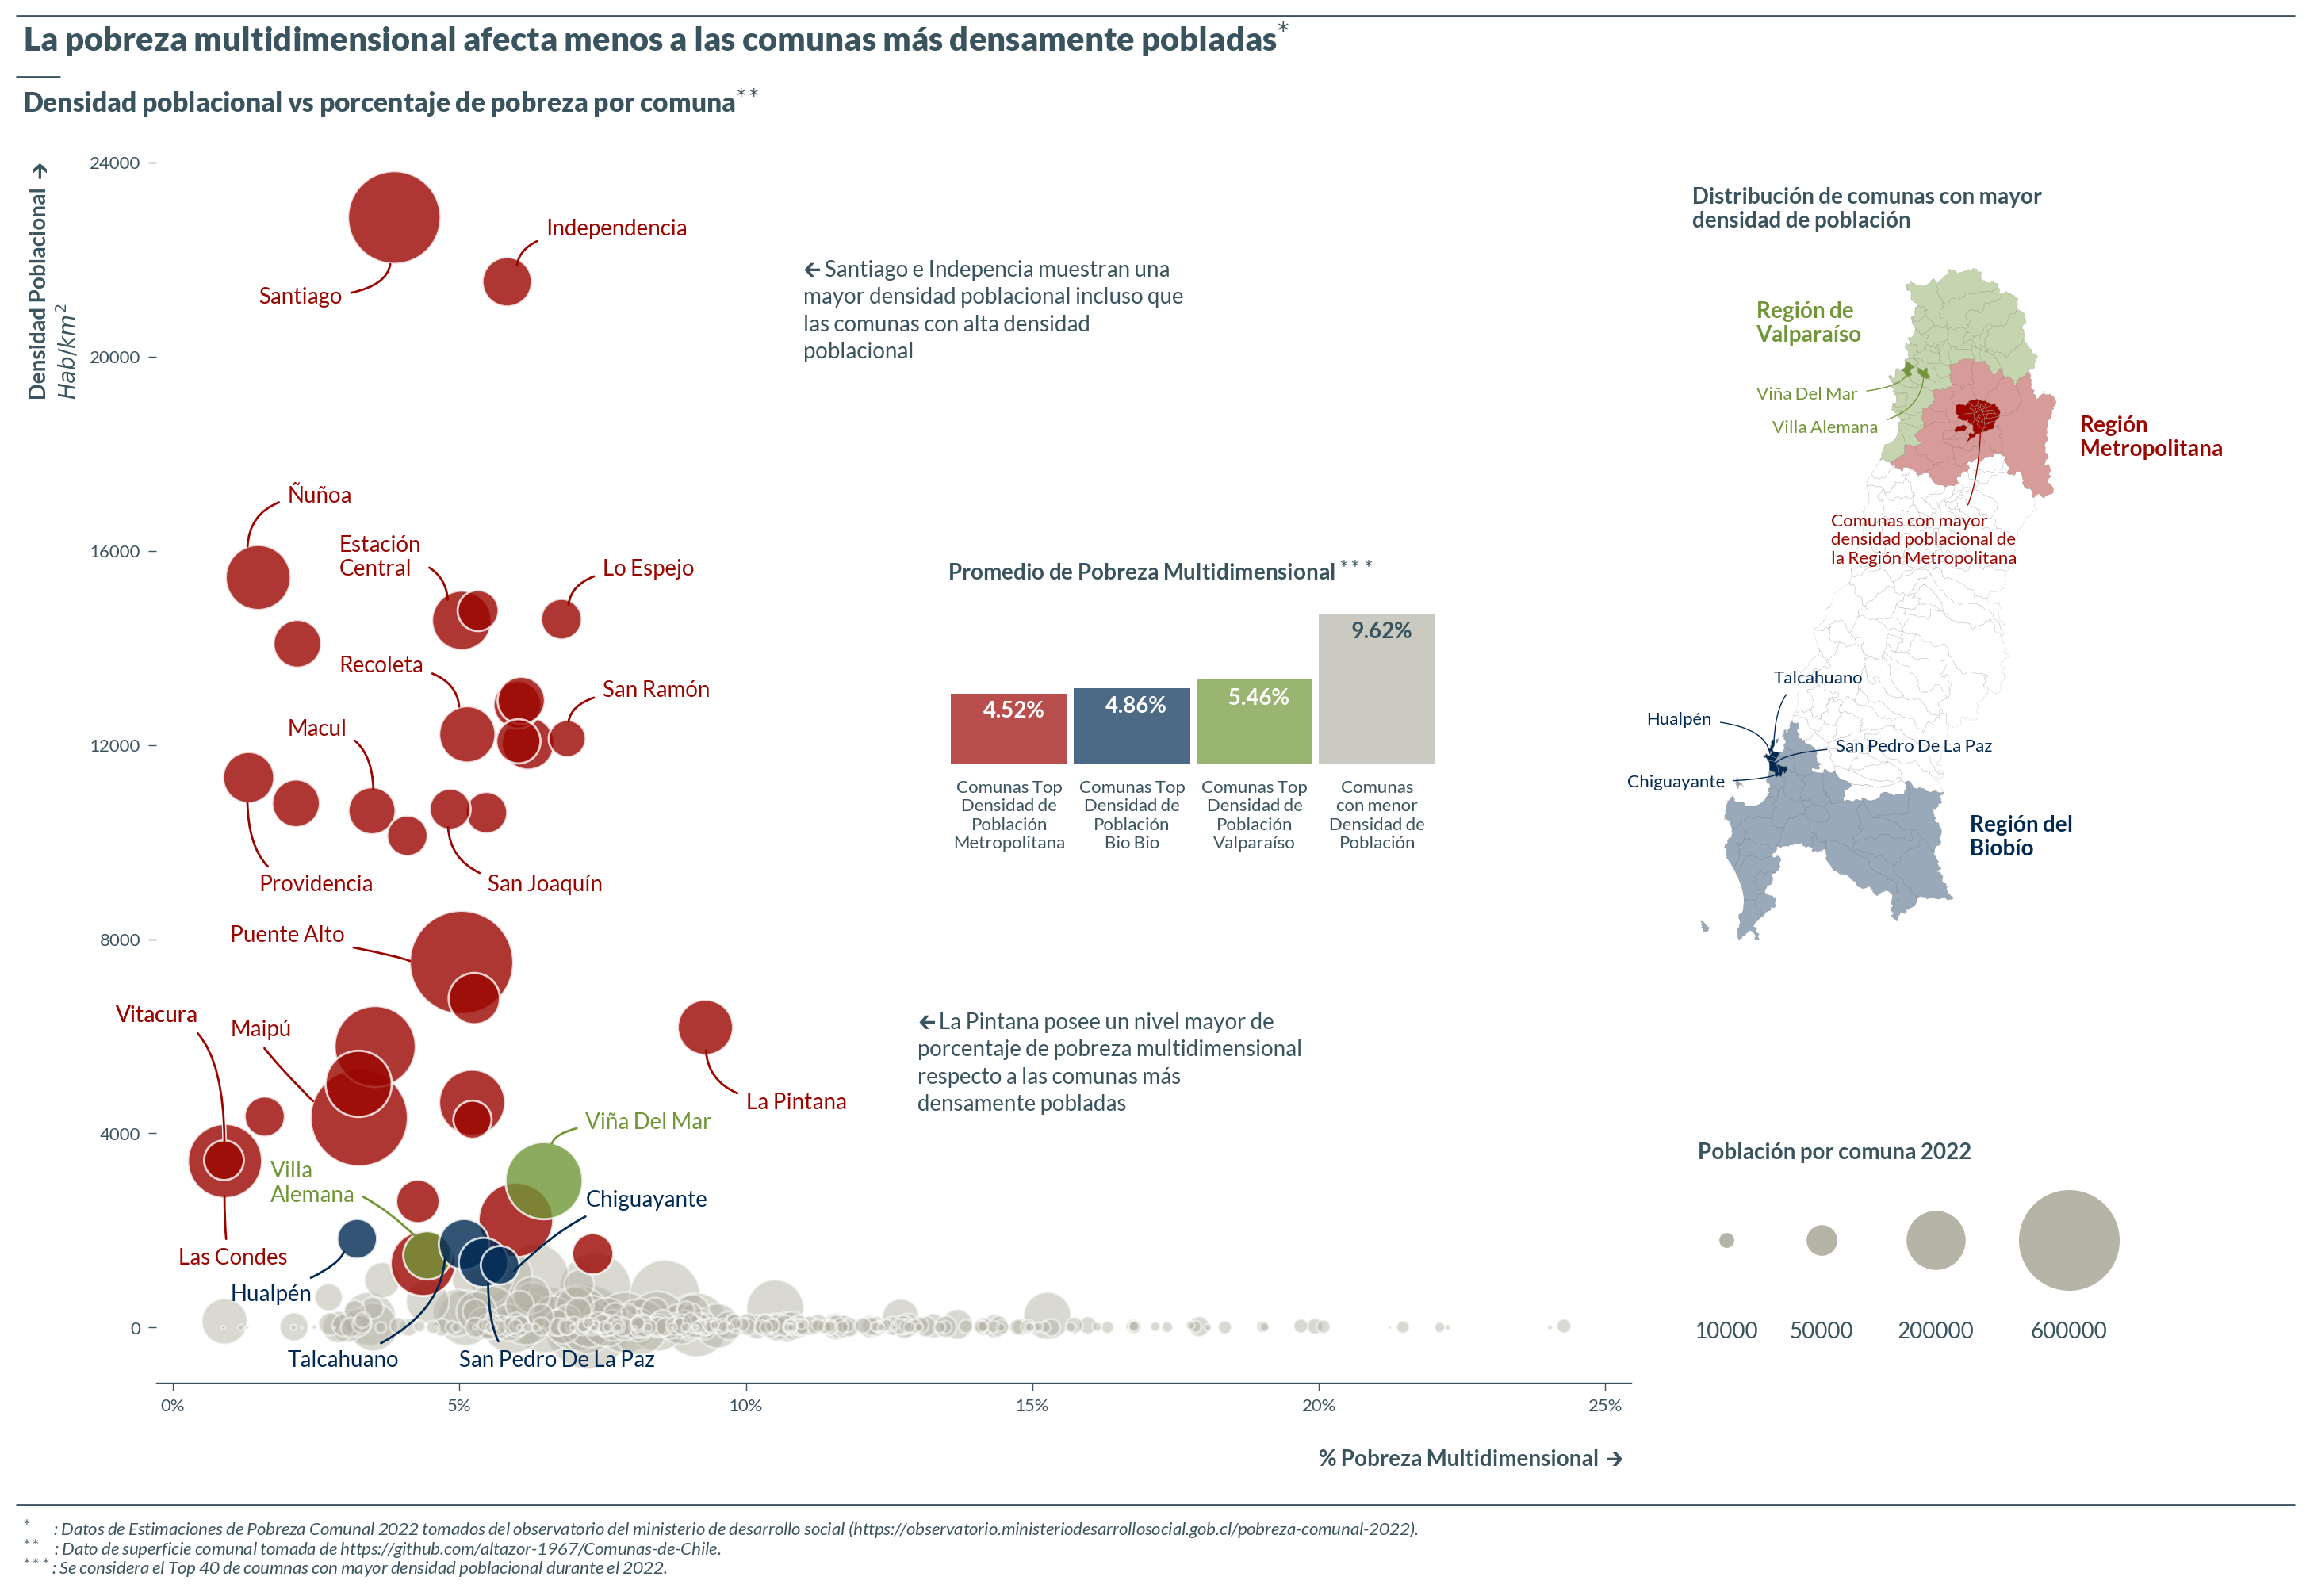

In [11]:
fig, ax = plt.subplots(1, figsize=(12,10), dpi=200)

n_size = 300

df_merge_2_ = df_merge_2[~df_merge_2.comuna_x.isin(comunas_top_densidad.comuna_x)].sort_values('poblacion',ascending=False)
ax.scatter(x=df_merge_2_['porcentaje_pobreza_multidimensional_2022'], y=df_merge_2_['densidad_pob_2022'], 
            s=df_merge_2_['poblacion']/n_size, color=gradient_bad, alpha=0.5, edgecolor='w')

for r in comunas_top_densidad.region.unique():
    df_merge_2_ = df_merge_2[df_merge_2.comuna_x.isin(comunas_top_densidad[comunas_top_densidad.region==r].comuna_x)].sort_values('poblacion',ascending=False)
    ax.scatter(x=df_merge_2_['porcentaje_pobreza_multidimensional_2022'], y=df_merge_2_['densidad_pob_2022'], 
    s=df_merge_2_['poblacion']/n_size, color=color_region[r], alpha=0.8, edgecolor='w')


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_linewidth(0.5)
ax.spines[:].set_color(colorGrayText)

ax.set_xticks(ax.get_xticks()[1:-1])
ax.set_xticklabels([str(int(100*x))+'%' for x in ax.get_xticks()], fontproperties=prop_latoR, color=colorGrayText, fontsize=8)
ax.tick_params(axis='x', width=0.5, color=colorGrayText)
ax.set_yticks([i*4000 for i in range(7)])
ax.set_yticklabels([str(int(x)) for x in ax.get_yticks()], fontproperties=prop_latoR, color=colorGrayText, fontsize=8)
ax.tick_params(axis='y', width=0.5, color=colorGrayText)

map_region_color_top_densidad(fig, pos=[0.83, 0.25, 0.4, 0.7], comunas=comunas, comunas_top_densidad=comunas_top_densidad, color_region=color_region, color_gray=gradient_bad, alpha=0.4)

mean_comunas_top_densidad = df_merge_2[df_merge_2.comuna_x.isin(comunas_top_densidad.comuna_x)].groupby('region')['porcentaje_pobreza_multidimensional_2022'].mean()
mean_comunas_top_densidad['Resto'] = df_merge_2[~df_merge_2.comuna_x.isin(comunas_top_densidad.comuna_x)]['porcentaje_pobreza_multidimensional_2022'].mean()
mean_comunas_top_densidad = (mean_comunas_top_densidad * 100).round(2)
mean_comunas_top_densidad = mean_comunas_top_densidad.sort_values()
barplot_media_pobreza(fig, pos=[0.53, 0.5, 0.28, 0.1], mean_comunas_top_densidad=mean_comunas_top_densidad.sort_values(), 
        color=[color_region['Metropolitana'], color_region['Biobío'], color_region['Valparaíso'], gradient_bad],
        ticklabels=["Comunas Top\nDensidad de\nPoblación\nMetropolitana", "Comunas Top\nDensidad de\nPoblación\nBio Bio", "Comunas Top\nDensidad de\nPoblación\nValparaíso", "Comunas\ncon menor\nDensidad de\nPoblación"],
        title='Promedio de Pobreza Multidimensional $^{***}$', pos_text=[-0.5, 13])

x_=0.35-0.07
y_=-0.2
drawCircleText(fig, np.array(600000.0), pos=[0.75+x_, 0.25+y_, 0.2, 0.3], pos_point = [3.0, 1.0], pos_text = [3.0, 0.93],
                ha_title = 'center', va_title = 'top', stext = 10, n_size=n_size)
drawCircleText(fig, np.array(200000.0), pos=[0.68+x_, 0.25+y_, 0.2, 0.3], pos_point = [3.0, 1.0], pos_text = [3.0, 0.93],
                ha_title = 'center', va_title = 'top', stext = 10, n_size=n_size)
drawCircleText(fig, np.array(50000.0), pos=[0.62+x_, 0.25+y_, 0.2, 0.3], pos_point = [3.0, 1.0], pos_text = [3.0, 0.93],
                ha_title = 'center', va_title = 'top', stext = 10, n_size=n_size)
drawCircleText(fig, np.array(10000.0), pos=[0.57+x_, 0.25+y_, 0.2, 0.3], pos_point = [3.0, 1.0], pos_text = [3.0, 0.93],
                ha_title = 'center', va_title = 'top', stext = 10, n_size=n_size)
drawCircleText(fig, np.array(0), pos=[0.555+x_, 0.35+y_, 0.2, 0.3], pos_point = [3.0, 1.0], pos_text = [3.0, 0.93],
                ha_title = 'left', va_title = 'bottom', stext = 10, n_size=n_size,
                title='Población por comuna 2022')

# Anotaciones scatter
# Metropolitana
ax.annotate('Santiago', xy=(0.038, 22000), xycoords='data',
            xytext=(0.015, 21100), textcoords='data', fontsize=10, color=color_region['Metropolitana'], fontproperties=prop_latoR,
            arrowprops=dict(arrowstyle='-', connectionstyle="angle3,angleA=0,angleB=-90", color=color_region['Metropolitana']))
ax.annotate('Independencia', xy=(0.06, 21800), xycoords='data',
            xytext=(0.065, 22500), textcoords='data', fontsize=10, color=color_region['Metropolitana'], fontproperties=prop_latoR,
            arrowprops=dict(arrowstyle='-', connectionstyle="angle3,angleA=0,angleB=-90", color=color_region['Metropolitana']))
ax.annotate('La Pintana', xy=(0.093, 5800), xycoords='data',
            xytext=(0.1, 4000+500), textcoords='data', fontsize=10, color=color_region['Metropolitana'], fontproperties=prop_latoR,
            arrowprops=dict(arrowstyle='-', connectionstyle="angle3,angleA=0,angleB=-90", color=color_region['Metropolitana']))
ax.annotate('Las Condes', xy=(0.009, 2800), xycoords='data',
            xytext=(0.001, 1300), textcoords='data', fontsize=10, color=color_region['Metropolitana'], fontproperties=prop_latoR,
            arrowprops=dict(arrowstyle='-', connectionstyle="angle3,angleA=20,angleB=-90", color=color_region['Metropolitana']))
ax.annotate('Vitacura', xy=(0.009, 3800), xycoords='data',
            xytext=(-0.01, 6300), textcoords='data', fontsize=10, color=color_region['Metropolitana'], fontproperties=prop_latoR,
            arrowprops=dict(arrowstyle='-', connectionstyle="angle3,angleA=0,angleB=-90", color='w', linewidth=2))
ax.annotate('Vitacura', xy=(0.009, 3750), xycoords='data', 
            xytext=(-0.01, 6300), textcoords='data', fontsize=10, color=color_region['Metropolitana'], fontproperties=prop_latoR,
            arrowprops=dict(arrowstyle='-', connectionstyle="angle3,angleA=0,angleB=-90", color=color_region['Metropolitana']))
ax.annotate('Providencia', xy=(0.013, 10900), xycoords='data', 
            xytext=(0.015, 9000), textcoords='data', fontsize=10, color=color_region['Metropolitana'], fontproperties=prop_latoR,
            arrowprops=dict(arrowstyle='-', connectionstyle="angle3,angleA=0,angleB=-90", color=color_region['Metropolitana']))
ax.annotate('Maipú', xy=(0.025, 4600), xycoords='data', 
            xytext=(0.01, 6000), textcoords='data', fontsize=10, color=color_region['Metropolitana'], fontproperties=prop_latoR,
            arrowprops=dict(arrowstyle='-', connectionstyle="angle3,angleA=-10,angleB=-45", color=color_region['Metropolitana']))
ax.annotate('Ñuñoa', xy=(0.013, 16000), xycoords='data', 
            xytext=(0.02, 17000), textcoords='data', fontsize=10, color=color_region['Metropolitana'], fontproperties=prop_latoR,
            arrowprops=dict(arrowstyle='-', connectionstyle="angle3,angleA=0,angleB=-90", color=color_region['Metropolitana']))
ax.annotate('Estación\nCentral', xy=(0.048, 14900), xycoords='data', 
            xytext=(0.029, 15500), textcoords='data', fontsize=10, color=color_region['Metropolitana'], fontproperties=prop_latoR,
            arrowprops=dict(arrowstyle='-', connectionstyle="angle3,angleA=0,angleB=-90", color=color_region['Metropolitana']))
ax.annotate('Recoleta', xy=(0.05, 12700), xycoords='data', 
            xytext=(0.029, 13500), textcoords='data', fontsize=10, color=color_region['Metropolitana'], fontproperties=prop_latoR,
            arrowprops=dict(arrowstyle='-', connectionstyle="angle3,angleA=0,angleB=-90", color=color_region['Metropolitana']))
ax.annotate('Lo Espejo', xy=(0.069, 14800), xycoords='data', 
            xytext=(0.075, 15500), textcoords='data', fontsize=10, color=color_region['Metropolitana'], fontproperties=prop_latoR,
            arrowprops=dict(arrowstyle='-', connectionstyle="angle3,angleA=0,angleB=-90", color=color_region['Metropolitana']))
ax.annotate('San Ramón', xy=(0.069, 12400), xycoords='data', 
            xytext=(0.075, 13000), textcoords='data', fontsize=10, color=color_region['Metropolitana'], fontproperties=prop_latoR,
            arrowprops=dict(arrowstyle='-', connectionstyle="angle3,angleA=0,angleB=-90", color=color_region['Metropolitana']))
ax.annotate('Macul', xy=(0.035, 11000), xycoords='data', 
            xytext=(0.02, 12200), textcoords='data', fontsize=10, color=color_region['Metropolitana'], fontproperties=prop_latoR,
            arrowprops=dict(arrowstyle='-', connectionstyle="angle3,angleA=0,angleB=-90", color=color_region['Metropolitana']))
ax.annotate('Puente Alto', xy=(0.042, 7500), xycoords='data', 
            xytext=(0.01, 7950), textcoords='data', fontsize=10, color=color_region['Metropolitana'], fontproperties=prop_latoR,
            arrowprops=dict(arrowstyle='-', connectionstyle="angle3,angleA=-10,angleB=90", color=color_region['Metropolitana']))
ax.annotate('San Joaquín', xy=(0.093-0.045, 5800+4600), xycoords='data',
            xytext=(0.11-0.055, 4000+5000), textcoords='data', fontsize=10, color=color_region['Metropolitana'], fontproperties=prop_latoR,
            arrowprops=dict(arrowstyle='-', connectionstyle="angle3,angleA=0,angleB=-90", color=color_region['Metropolitana']))
# Valparaíso
ax.annotate('Viña Del Mar', xy=(0.066, 3700), xycoords='data', 
            xytext=(0.072, 4100), textcoords='data', fontsize=10, color=color_region['Valparaíso'], fontproperties=prop_latoR,
            arrowprops=dict(arrowstyle='-', connectionstyle="angle3,angleA=0,angleB=-90", color=color_region['Valparaíso']))
ax.annotate('Villa\nAlemana', xy=(0.043, 1800), xycoords='data',
            xytext=(0.017, 2600), textcoords='data', fontsize=10, color=color_region['Valparaíso'], fontproperties=prop_latoR,
            arrowprops=dict(arrowstyle='-', connectionstyle="angle3,angleA=0,angleB=-45", color=color_region['Valparaíso']))
# Biobío
ax.annotate('Hualpén', xy=(0.03, 1650), xycoords='data',
            xytext=(0.01, 550), textcoords='data', fontsize=10, color=color_region['Biobío'], fontproperties=prop_latoR,
            arrowprops=dict(arrowstyle='-', connectionstyle="angle3,angleA=20,angleB=-90", color=color_region['Biobío']))
ax.annotate('Talcahuano', xy=(0.0475, 1550), xycoords='data',
            xytext=(0.02, -800), textcoords='data', fontsize=10, color=color_region['Biobío'], fontproperties=prop_latoR,
            arrowprops=dict(arrowstyle='-', connectionstyle="angle3,angleA=20,angleB=-90", color=color_region['Biobío']))
ax.annotate('San Pedro De La Paz', xy=(0.055, 1000), xycoords='data',
            xytext=(0.05, -800), textcoords='data', fontsize=10, color=color_region['Biobío'], fontproperties=prop_latoR,
            arrowprops=dict(arrowstyle='-', connectionstyle="angle3,angleA=20,angleB=-90", color=color_region['Biobío']))
ax.annotate('Chiguayante', xy=(0.059, 1100), xycoords='data',
            xytext=(0.072, 2500), textcoords='data', fontsize=10, color=color_region['Biobío'], fontproperties=prop_latoR,
            arrowprops=dict(arrowstyle='-', connectionstyle="angle3,angleA=0,angleB=45", color=color_region['Biobío']))

# Ejes
# Eje x
x_=0.03
y_=-2500
ax.text(0.17+x_, 0.07+y_, "% Pobreza Multidimensional", ha='left', va='top', 
            fontsize=10, weight=900, 
            color=colorGrayText, fontproperties=prop_latoB)
ax.text(0.22+x_, 0.07+y_, "🡲", ha='left', va='top', 
            fontsize=10, weight=900, 
            color=colorGrayText, fontproperties=prop_noto2)
# Eje y
x_=-0.025
y_=23500
ax.text(0.+x_, 0.+y_, 'Densidad Poblacional\n'+'$Hab/km^2$', ha='left', va='top', rotation=90,
            fontsize=10, weight=900, 
            color=colorGrayText, fontproperties=prop_latoB)
ax.text(0.+x_, 550+y_, "🡲", ha='left', va='top', rotation=90,
            fontsize=10, weight=900, 
            color=colorGrayText, fontproperties=prop_noto2)

# Comentarios
annotate_fig(ax, '     Santiago e Indepencia muestran una\nmayor densidad poblacional incluso que\nlas comunas con alta densidad\npoblacional', 
                [0.11, 22000], '🡰', [0.11, 22000], [1.4, 1.4])

annotate_fig(ax, '     La Pintana posee un nivel mayor de\nporcentaje de pobreza multidimensional\nrespecto a las comunas más\ndensamente pobladas', 
                [0.13, 6500], '🡰', [0.13, 6500], [1.4, 1.4])


# Titulo
posx_line_title = [0.045-0.09-0.05, 1.45]
posy_line_title = [1.23-.11, 1.23-.11]
lw_line_title = 1
pos_x0_title = 0.16-0.105
pos_y0_title = 1.05-.08
title_fig(fig, ax, posx_line_title, posy_line_title, colorGrayText, colorGrayText,
        "La pobreza multidimensional afecta menos a las comunas más densamente pobladas$^{*}$",
        lw_line_title, pos_x0_title, pos_y0_title, fontsize=15)

posx_line_title = [0.045-0.09-0.05, 0.045-0.09+0.03-0.05]
posy_line_title = [1.2-.13, 1.2-.13]
lw_line_title = 1
pos_x0_title = 0.16-0.105
pos_y0_title = 1.05-0.122
title_fig(fig, ax, posx_line_title, posy_line_title, colorGrayText, colorGrayText,
        "Densidad poblacional vs porcentaje de pobreza por comuna$^{**}$",
        lw_line_title, pos_x0_title, pos_y0_title, fontsize=12)

# pie de pagina
posx_line_title = [0.045-0.09-0.05, 1.45]
posy_line_title = [-0.1, -0.1]
lw_line_title = 1
pos_x0_title = 0.16-0.105
pos_y0_title = 0.025
title_fig(fig, ax, posx_line_title, posy_line_title, colorGrayText, colorGrayText,
        "$^{*}$       : Datos de Estimaciones de Pobreza Comunal 2022 tomados del observatorio del ministerio de desarrollo social (https://observatorio.ministeriodesarrollosocial.gob.cl/pobreza-comunal-2022).\n"+
        "$^{**}$    : Dato de superficie comunal tomada de https://github.com/altazor-1967/Comunas-de-Chile.\n"
        "$^{***}$: Se considera el Top 40 de coumnas con mayor densidad poblacional durante el 2022.",
        lw_line_title, pos_x0_title, pos_y0_title, fontsize=8, fontproperties=prop_latoI, linespacing=0.8)